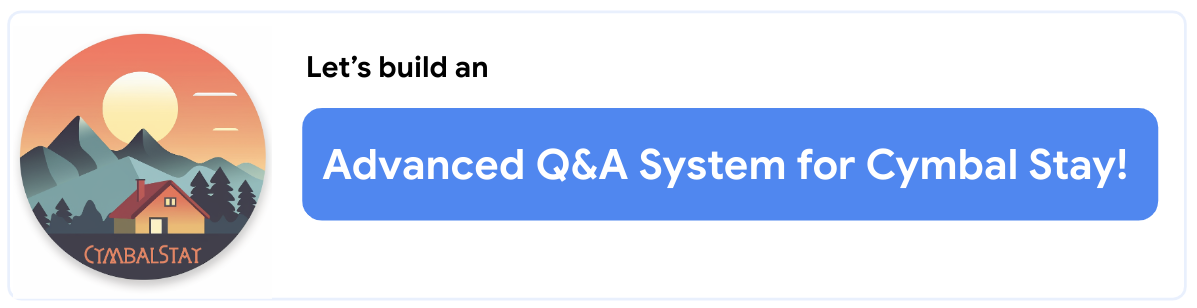

In [2]:
from IPython.display import Image
Image("img/head.png", width=800)

In [2]:
# Welcome to Cymbal Hotels and More

# In this notebook: We will build an Advanced Search Application from scratch
# The Applicaiton will leverage - Palm as a base-model and the gecko-embeddings-model
# In detail - we will explore the following technologies:

########################
# 1 Introduction to RAG 
######################## 

########################
# 2 DocAI Form Parser
########################

########################
# 3 Embeddings Model (via gecko)
########################

########################
# 4 ScaNN
########################

########################
# 5 Building Full Promot with Instructions and Context
########################


########################
# Steps in this Workbook
########################
# 1: Setup / Define Variables / Environment
# 2: Install dependencies
# 3: Enable APIs
# 4: Import dependencies
# 5: Define: Client, Location, Model(s)
# 6: Compute Embedding Values for User Question (based on Embdding Model)
# 7: Test: Question without RAG
# 8: Download additional context from GCS Bucket
# 9: Read-in context as PDF on-page-basis as bytes
# 10: Initiate Form Parser as Processor
# 11: Parsing the PDFs
# 12: Extracting Tables and Text
# 13: Create embeddings of extracted text
# 14: Indexing and normalizing the index
# 15: Building a ScaNN Builder
# 16: Building a ScaNN tree
# 17: Building a Searcher using ScaNN
# 18: Takes a query text string and the number of nearest neighbors to return (k) as input
# 19 Building Final Promot with Instructions and Context


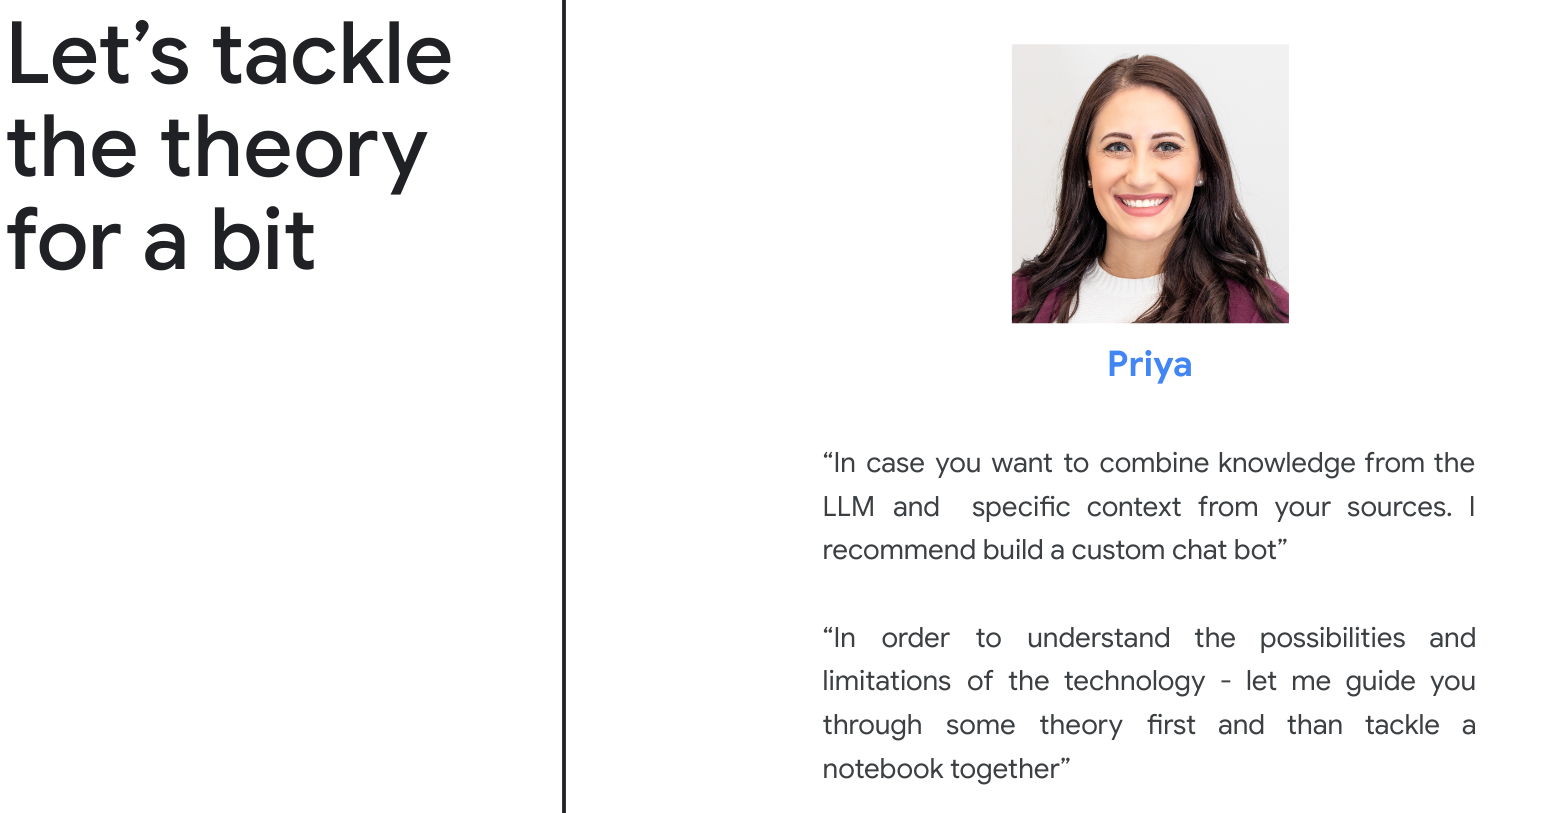

In [3]:
Image("img/priya_1.png", width=800)


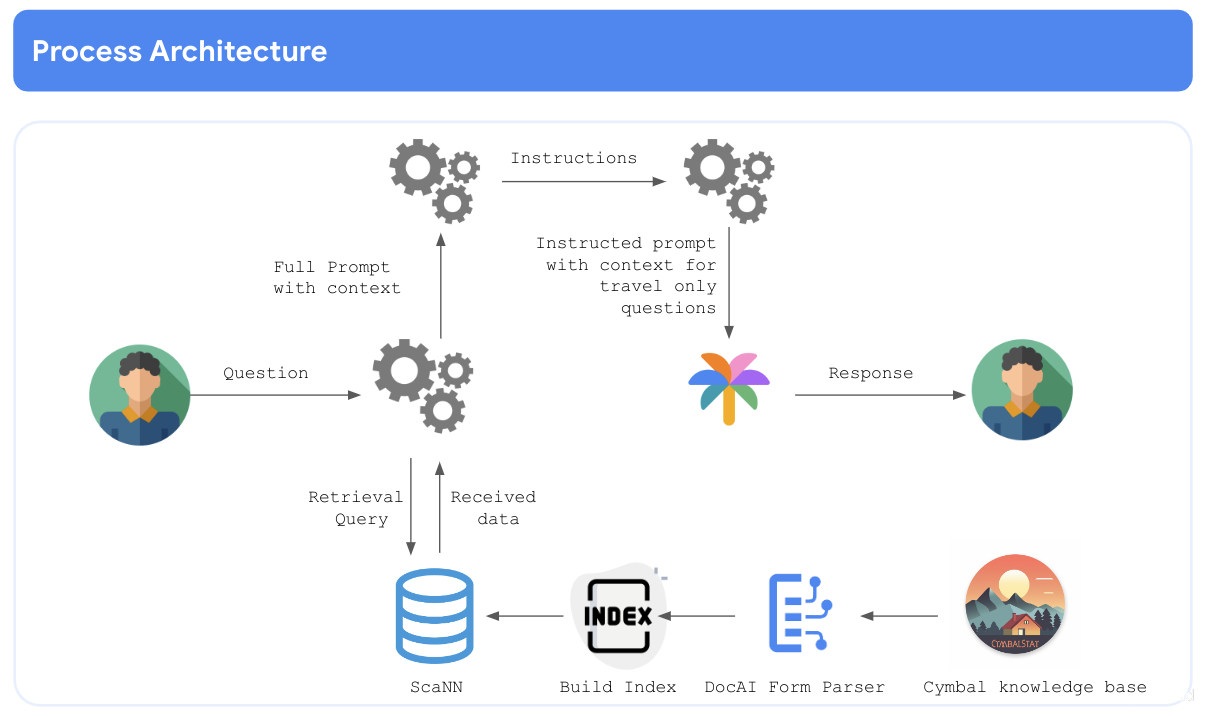

In [4]:
Image("img/process.png", width=800)

In [8]:
# Setup of Project
project = !gcloud config get-value project
PROJECT_ID = project[0]
PROJECT_ID

'csm-ml-demos'

In [9]:
# Predefined-Variales 
REGION = 'us-central1'
GCS_BUCKET = 'csm-genai-bucket'
example_question = "What are essential amenities for guests?"

# Merged PDF
source_document = 'full_cymbal_stay.pdf' #Full PDF with all documents
print(source_document)

full_cymbal_stay.pdf


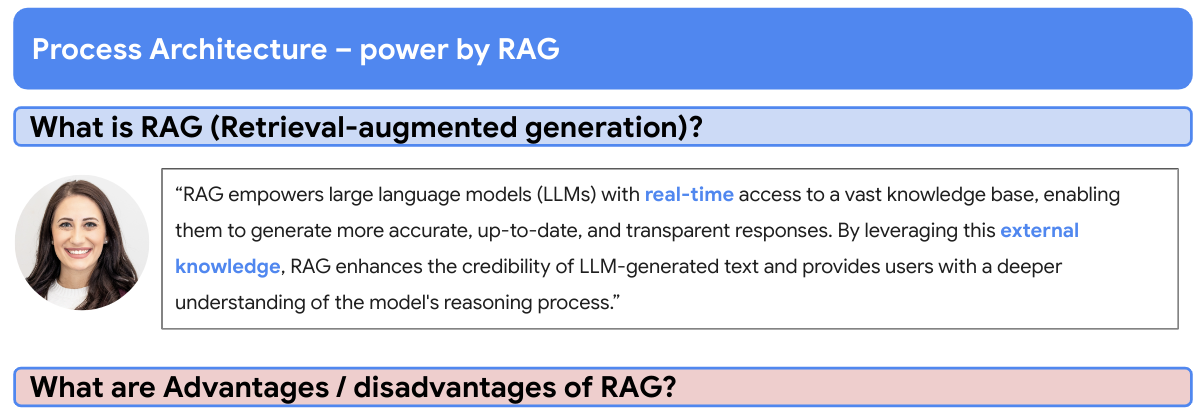

In [10]:
Image("img/pryia_2aa.png", width=800)

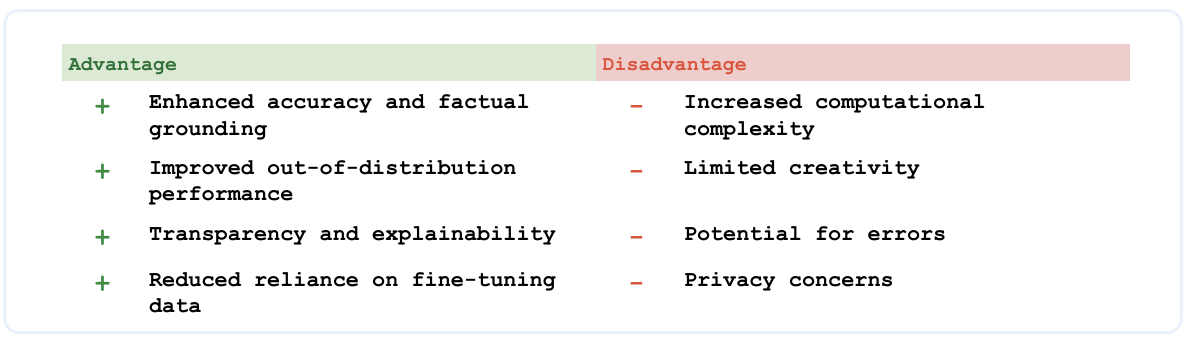

In [11]:
### Answer:  (Uncomment to see answer)
Image("img/priya_2b.png", width=800)

In [12]:
# Vertex AI GenAI Studio SDK
!pip install google.cloud.aiplatform

# ScaNN: Efficient Vector Similarity Search using Anisotropic Vector Quantization
# see explanation by CSM:go/CSM-ScaNN
!pip install scann

# For GCP DocAI and presentation of results
!pip install google-cloud-documentai
!pip install PyPDF2
!pip install Pillow

#PyPDF2: I order to read-in the pdf from the blob storage
#Pillow: In order to crete the document_image via PIL.Image.open

In [13]:
# Enable Document AI For This Project
!gcloud services enable documentai.googleapis.com
# Enable Vertex AI For This Project
!gcloud services enable aiplatform.googleapis.com

In [14]:
# Make sure version is greater than 1.25.0
import google.cloud.aiplatform as aiplatform
aiplatform.__version__

'1.33.1'

In [15]:
import os
import io
import json
import base64
import requests
import concurrent.futures
import time

import PyPDF2
import IPython
import PIL
import PIL.ImageFont, PIL.Image, PIL.ImageDraw
import shapely #For Drawing Bounding Boxes

import scann
import numpy as np

import vertexai.preview.language_models
from google.cloud import aiplatform
from google.cloud import documentai
from google.cloud.documentai_v1 import Document
from google.cloud import storage

In [16]:
# Vertex ai clients
vertexai.init(project = PROJECT_ID, location = REGION)
aiplatform.init(project = PROJECT_ID, location = REGION)

# document AI client
LOCATION = REGION.split('-')[0]
docai_client = documentai.DocumentProcessorServiceClient(
    client_options = dict(api_endpoint = f"{LOCATION}-documentai.googleapis.com")
)

# gcs client: assumes bucket already exists
gcs = storage.Client(project = PROJECT_ID)
bucket = gcs.bucket(GCS_BUCKET)

# create links to model: embedding api and text generation
embedding_model = vertexai.preview.language_models.TextEmbeddingModel.from_pretrained('textembedding-gecko@001') #Updated version with enhanced AI quality
textgen_model = vertexai.preview.language_models.TextGenerationModel.from_pretrained('text-bison@001')

In [17]:
# Retrieve all documents from path
storage_client = storage.Client()
bucket = storage_client.get_bucket(GCS_BUCKET)
blobs = bucket.list_blobs(prefix='cymbal_stay/')
document_paths = []
document_list = []

for blob in blobs:
    document_paths.append(blob.name)
    
    try:
        num = blob.name.count('/')
        string = blob.name.split('/')[num]
        if string != "":
            #print(string)
            document_list.append(string)
    except:
        print("An exception occurred") 
    
source_documents = document_paths[1:]
print(source_documents)

['cymbal_stay/Essential Amenities.pdf', 'cymbal_stay/Extenuating Circumstances Policy.pdf', 'cymbal_stay/Guest Check-in.pdf', 'cymbal_stay/Guest Pricing.pdf', 'cymbal_stay/Guest Refund Policy.pdf', 'cymbal_stay/Guest Reservation Changes.pdf', 'cymbal_stay/Host Cancellation Policy.pdf', 'cymbal_stay/Host Cancellation.pdf', 'cymbal_stay/Host Ground Rules.pdf', 'cymbal_stay/Host Response Time.pdf', 'cymbal_stay/Host Suspension.pdf', 'cymbal_stay/Service Fees.pdf', 'cymbal_stay/Ways to host on CymbalStay.pdf']


In [18]:
# !pip install pypdf
# import pypdf
# from pypdf import PdfMerger

# pdfs = [source_documents]

# merger = PdfMerger()

# for pdf in pdfs:
#     merger.append(pdf)

# merger.write("result.pdf")
# merger.close()

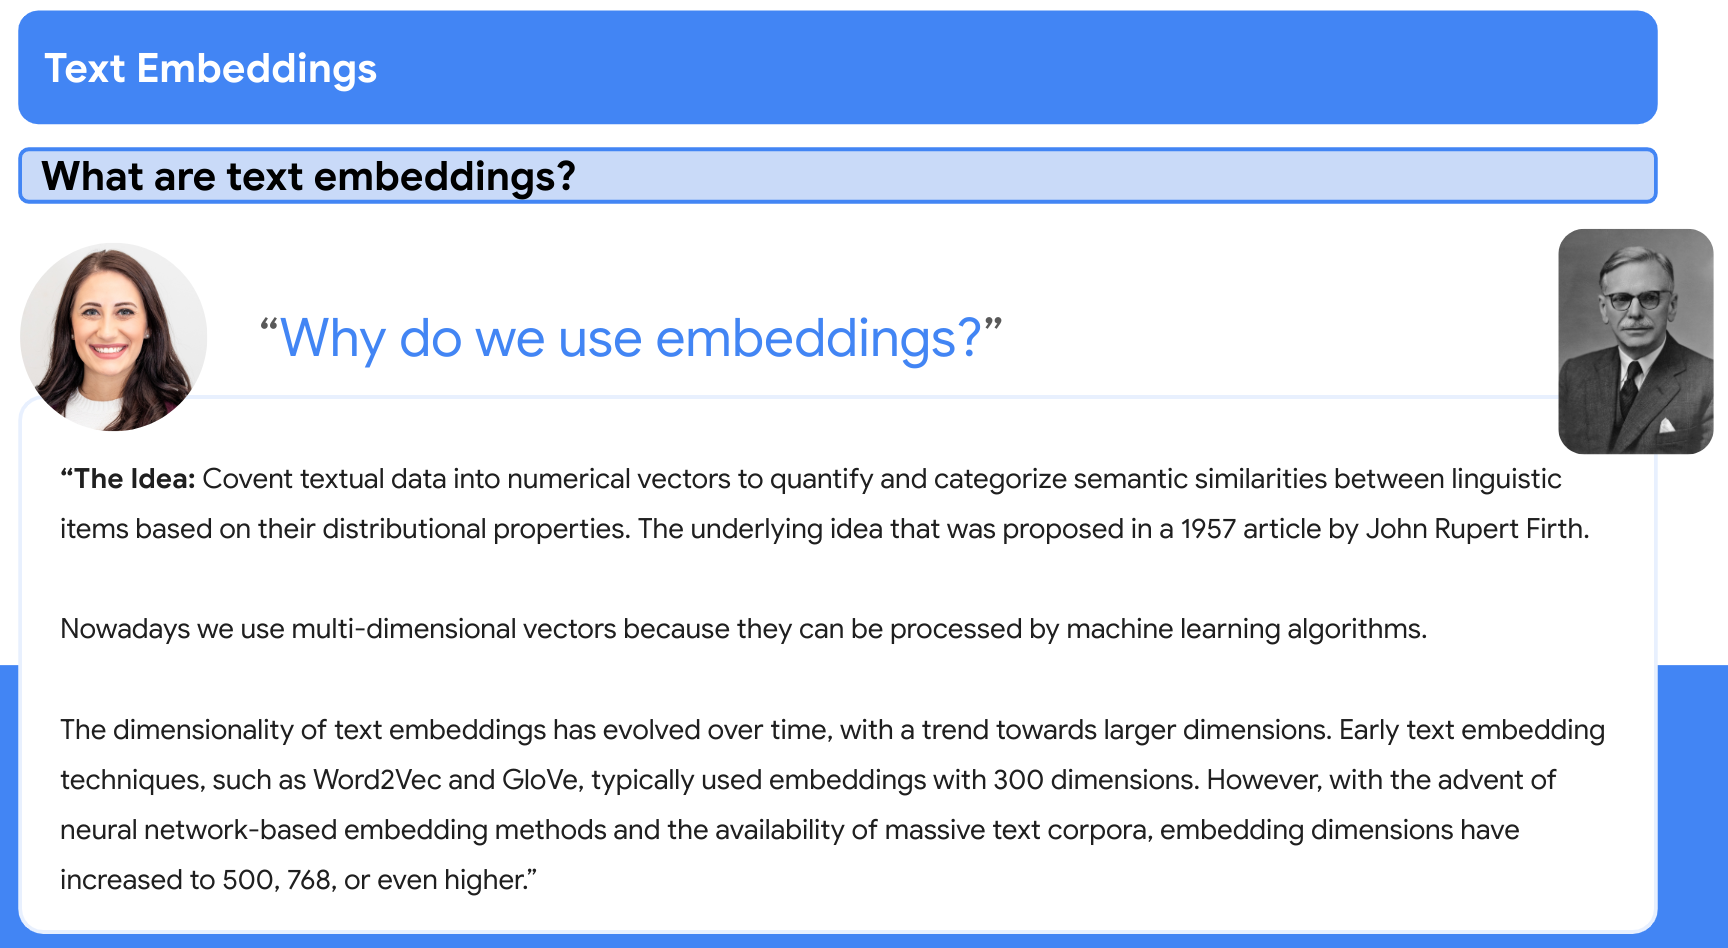

In [19]:
Image("img/priya_6.png", width=800)

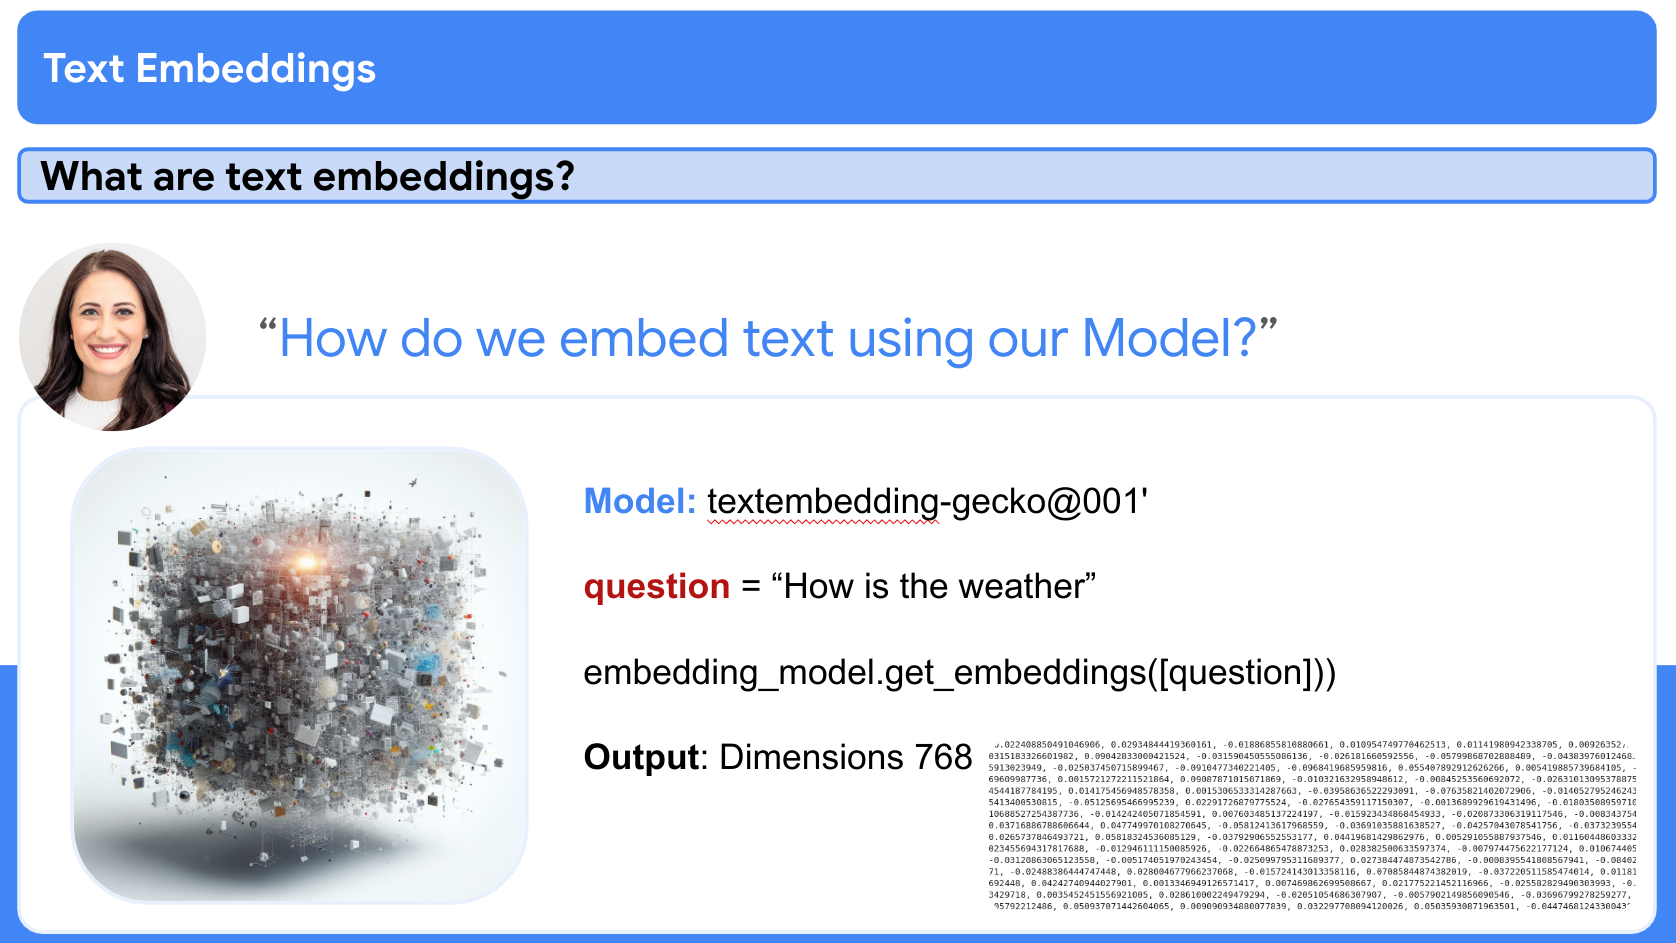

In [20]:
Image("img/priya_7.png", width=800)

In [21]:
# Compute Embeddings Values for User Question
embeddings_review = embedding_model.get_embeddings([example_question])[0] 
# 0 stands for the embedding VALUES
# Other output:  deployed_model_id, model_version_id, model_resource_name, explanations

# Get Number of Dimension of Embeddings
# Gecko Embedding Model is limited to 768 dimensions
len(embedding_model.get_embeddings([example_question])[0].values)

768

In [22]:
# Prediction of Question -- when using LLM without RAG context:
textgen_model.predict(example_question)

* **A comfortable bed.** This is probably the most important amenity for guests, as they need a place to rest their heads after a long day of travel. A comfortable bed should be made with high-quality bedding and have plenty of pillows and blankets.
* **A clean bathroom.** Guests also need a clean bathroom to use, so it's important to make sure that the toilet, sink, and shower are clean and well-maintained.
* **Adequate lighting.** Guests need enough light to see their way around the room, so make sure that there are plenty of lamps or overhead lights.
*

In [23]:
bucket = gcs.bucket(GCS_BUCKET)
blob = bucket.blob(source_document)
response = blob.download_as_bytes()

## Optional download to local storage
response = blob.download_as_bytes()

In [24]:
print(source_documents)

imported_documents = []
for s in (source_documents):
        #print(s)
        blob = bucket.blob(s)
        imported_documents.append(blob.download_as_bytes())
        
#response = source_document
# print(response[4])

['cymbal_stay/Essential Amenities.pdf', 'cymbal_stay/Extenuating Circumstances Policy.pdf', 'cymbal_stay/Guest Check-in.pdf', 'cymbal_stay/Guest Pricing.pdf', 'cymbal_stay/Guest Refund Policy.pdf', 'cymbal_stay/Guest Reservation Changes.pdf', 'cymbal_stay/Host Cancellation Policy.pdf', 'cymbal_stay/Host Cancellation.pdf', 'cymbal_stay/Host Ground Rules.pdf', 'cymbal_stay/Host Response Time.pdf', 'cymbal_stay/Host Suspension.pdf', 'cymbal_stay/Service Fees.pdf', 'cymbal_stay/Ways to host on CymbalStay.pdf']


In [25]:
### Read as PDF Object
pdf = PyPDF2.PdfReader(io.BytesIO(response))

### Put PDF object as Bytes into array for each page
pdfs = []
for page_num, page in enumerate(pdf.pages, 1):
  writer = PyPDF2.PdfWriter()
  writer.add_page(page)
  with io.BytesIO() as bytes_stream:
    pdfs.append(writer.write(bytes_stream)[1].getbuffer().tobytes())
   
### Size of PDF(s)
print(len(pdf.pages))
print(len(pdfs))

29
29


In [26]:
PARSER_DISPLAY_NAME = 'my_general_processor'
PARSER_TYPE = 'FORM_PARSER_PROCESSOR'

# # Form Parser Version 2.0: July 18, 2023 (State GA)
# PARSER_VERSION = 'pretrained-form-parser-v2.0-2022-11-10'

# # Form Parser Version 2.1: July 18, 2023 (State Public Preview)
PARSER_VERSION = 'pretrained-form-parser-v2.1-2023-06-26'

for p in docai_client.list_processors(parent = f'projects/{PROJECT_ID}/locations/{LOCATION}'):
  if p.display_name == PARSER_DISPLAY_NAME:
    parser = p
    print('Retrieved Existing Parser')
if 'parser' not in locals():
  parser = docai_client.create_processor(
      parent = f'projects/{PROJECT_ID}/locations/{LOCATION}',
      processor = dict(display_name = PARSER_DISPLAY_NAME, type_ = PARSER_TYPE, default_processor_version = PARSER_VERSION)
  )
  print('Created New Parser')

parser

Retrieved Existing Parser


name: "projects/367711338757/locations/us/processors/dae77d89d50df844"
type_: "FORM_PARSER_PROCESSOR"
display_name: "my_general_processor"
state: ENABLED
process_endpoint: "https://us-documentai.googleapis.com/v1/projects/367711338757/locations/us/processors/dae77d89d50df844:process"
create_time {
  seconds: 1697552677
  nanos: 598131000
}
default_processor_version: "projects/367711338757/locations/us/processors/dae77d89d50df844/processorVersions/pretrained-form-parser-v2.1-2023-06-26"
processor_version_aliases {
  alias: "projects/367711338757/locations/us/processors/dae77d89d50df844/processorVersions/pretrained"
  processor_version: "projects/367711338757/locations/us/processors/dae77d89d50df844/processorVersions/pretrained-form-parser-v1.0-2020-09-23"
}
processor_version_aliases {
  alias: "projects/367711338757/locations/us/processors/dae77d89d50df844/processorVersions/pretrained-next"
  processor_version: "projects/367711338757/locations/us/processors/dae77d89d50df844/processorVer

In [27]:
rate_limit_minute = 120
adjust_rate_limit = rate_limit_minute / 2

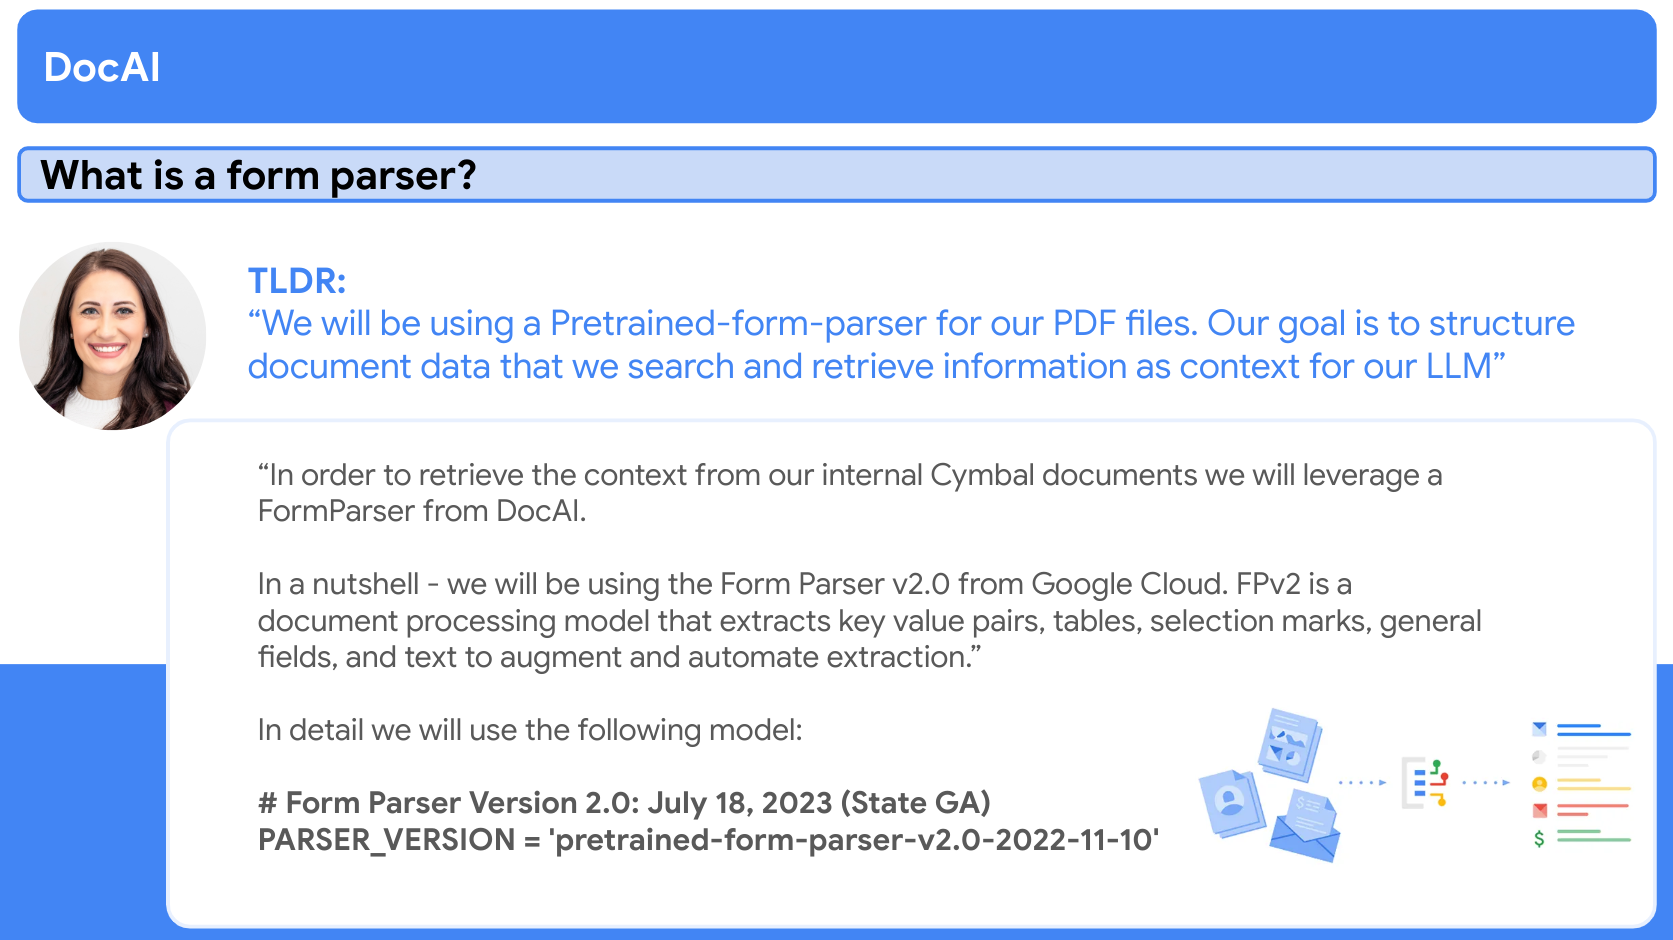

In [28]:
Image("img/priya_5.png", width=800)

In [29]:
def docai_runner(p, start, raw_document):
    
  process_options = documentai.ProcessOptions(
  # Process only specific pages
  individual_page_selector=documentai.ProcessOptions.IndividualPageSelector(
      pages=[1] # e.g. in case you only want to process individual pages
  )
  )

  # Configure the process request
  request = documentai.ProcessRequest(
        name=parser.name,
        raw_document=raw_document,
        process_options=process_options,
    )     
    
  sleep_time = (p * (60/adjust_rate_limit)) - (time.time() - start)
  if sleep_time > 0: time.sleep(sleep_time)
    
  return (p, docai_client.process_document(request = dict(raw_document = raw_document, name = parser.name)))

In [30]:
###
# This code is designed to parse multiple PDF documents using Document AI. It first prints a message indicating that it is parsing with Document AI and then estimates the expected runtime for the parsing process based on the number of PDFs and an adjustment rate limit.
# Next, it creates a list of empty results, one for each PDF document. It then starts a timer to measure the parsing time.
# Inside a concurrent.futures.ThreadPoolExecutor, it submits a task for each PDF document. Each task calls the docai_runner function, passing it the index of the PDF document, the start time of the timer, and a DocAI RawDocument object containing the PDF data.
# The executor runs the tasks concurrently, and the as_completed() method is used to wait for all of the tasks to finish. As each task completes, its result is stored in the results list.
# Finally, the code prints the time it took to parse the PDFs.
###

print('Parsing with Document AI')
print(f"The Expected runtime for the parsing is {(len(pdfs)/adjust_rate_limit):.2f} minutes")

results = [None] * len(pdfs)
start = time.time()
with concurrent.futures.ThreadPoolExecutor(max_workers = len(pdfs)) as executor:
    futures = [
        executor.submit(
            docai_runner,
            p, start,
            documentai.RawDocument(content = pdf, mime_type = 'application/pdf')
        ) for p, pdf in enumerate(pdfs)
    ]
    for future in concurrent.futures.as_completed(futures):
      results[future.result()[0]] = (Document.to_dict(future.result()[1].document))

Parsing with Document AI
The Expected runtime for the parsing is 0.48 minutes


In [31]:
# Evaluate DocAI Output Length and PDF Original Length (in pages)
len(pdfs), len(results)

(29, 29)

In [32]:
###
# 1: Adds order to results: It assigns a unique identifier (vme_id) to each result to maintain the order of the processed documents.
# 2: Extracts document images: It extracts the base64 encoded image data from each document and converts it into a PIL Image object. These images are stored in the page_images list.
# 3: Processes tables: For each table in the first page of each document, it performs the following steps:
# 3a. Extracts table text: It iterates through the text segments of the table layout and extracts the corresponding text from the overall document text.
# 3b. Extracts table bounding polygon: It extracts the normalized vertices of the table's bounding polygon and calculates the corresponding coordinates in the document image.
# 3c. Converts polygon to shapely object: It creates a shapely Polygon object representing the table's bounding polygon.
# 3d. Creates document entry: It creates a document entry for the table, including the extracted text, metadata (page, table number, vme_id, filename, source document), and extras (vertices).
# 4. Processes paragraphs: For each paragraph of each document.
# 5: Returns the number of documents: The code finally returns the length of the documents list, which represents the total number of processed documents (including tables and paragraphs).
###


documents = []
page_images = []
for r, result in enumerate(results):

    # add order to results:
    results[r]['metadata'] = dict(vme_id = str(r))

    document_image = PIL.Image.open(
        io.BytesIO(
            base64.decodebytes(result['pages'][0]['image']['content'].encode('utf-8'))
            )
        )
    page_images.append(document_image)

    tables = []
    for t, table in enumerate(result['pages'][0]['tables']):
      table_txt = ''
      if 'text_anchor' in table['layout'].keys():
        for s, segment in enumerate(table['layout']['text_anchor']['text_segments']):
          if t == 0 and s == 0: start = 0
          else: start = int(segment['start_index'])
          end = int(segment['end_index'])
          table_txt += result['text'][start:end+t]
          # print(table_txt)


      documents.append(
          dict(
              page_content = table_txt,
              metadata = dict(
                  page = r+1,
                  table = t+1,
                  vme_id = str(len(documents)),
                  filename = source_document.split('/')[-1],
                  source_document = source_document
              ),
              extras = dict(
                  vertices = vertices
              )
          )
      )

    for p, paragraph in enumerate(result['pages'][0]['paragraphs']):

      paragraph_txt = ''
      for s, segment in enumerate(paragraph['layout']['text_anchor']['text_segments']):
        if p == 0 and s == 0: start = 0
        else: start = int(segment['start_index'])
        end = int(segment['end_index'])
        paragraph_txt += result['text'][start:end+1]
        #print(paragraph_txt)

      vertices = []
      for vertex in paragraph['layout']['bounding_poly']['normalized_vertices']:
        vertices.append(dict(x = vertex['x'] * document_image.size[0], y = vertex['y'] * document_image.size[1]))

      # only use paragraph that are not within table boundaries
      use_paragraph = True
      for t_shape in tables:
        p_shape = shapely.geometry.Polygon([(v['x'], v['y']) for v in vertices])
        if p_shape.intersects(t_shape): use_paragraph = False

      if use_paragraph:
        documents.append(
            dict(
                page_content = paragraph_txt,
                metadata = dict(
                    page = r+1,
                    paragraph = p+1,
                    vme_id = str(len(documents)),
                    filename = source_document.split('/')[-1],
                    source_document = source_document
                ),
                extras = dict(
                    vertices = vertices
                )
            )
        )

len(documents)

276

In [33]:
rate_limit_minute = 150

In [34]:
###
# This code processes the extracted text from each document and generates corresponding embeddings using a specified embedding model. 
# It also limits the embedding generation rate to avoid exceeding usage limits.

# Detailed breakdown of the code:
# Estimates embedding generation time
# Starts a timer: It starts a timer to track the elapsed time during embedding generation.
# Iterates through documents: It iterates through the documents list, processing each document one by one.
# Limits embedding generation rate: For every rate_limit_minute document, it checks if the current time is within the specified time limit. If not, it sleeps for a calculated amount of time to adjust the embedding generation rate.
# Extracts document text: It retrieves the text content from the current document using the page_content key.
# Generates embeddings (if text exists): If the document contains text, it uses the embedding_model to generate embeddings for the text. It extracts the embedding vector from the generated result and stores it in the embed variable.
# Handles empty text: If the document contains no text, it sets the embed variable to an empty list.
# Adds embeddings to documents: It stores the generated embeddings (or the empty list) in the embedding key of the current document dictionary.
# Continues iteration: The loop continues until all documents have been processed.
# In summary, this code efficiently generates embeddings for the extracted text from each document while adhering to the specified rate limit to avoid exceeding usage restrictions.

print(f"The expected run time for embeddings is {(len(documents)/rate_limit_minute):.2f} minutes")
start = time.time()
for d, document in enumerate(documents):
    if d % rate_limit_minute == 0:
      time.sleep(((time.time() - start) % 60) + 10)
      start = time.time()
    text = document['page_content']
    if text:
      embed = embedding_model.get_embeddings([text])[0].values
    else:
      embed = []
    documents[d]['embedding'] = embed

The expected run time for embeddings is 1.84 minutes


In [35]:
# Initiatlizing NP Array
index = np.empty((len(documents), len(documents[0]['embedding'])))
index.shape

(276, 768)

In [36]:
type(results) == list

True

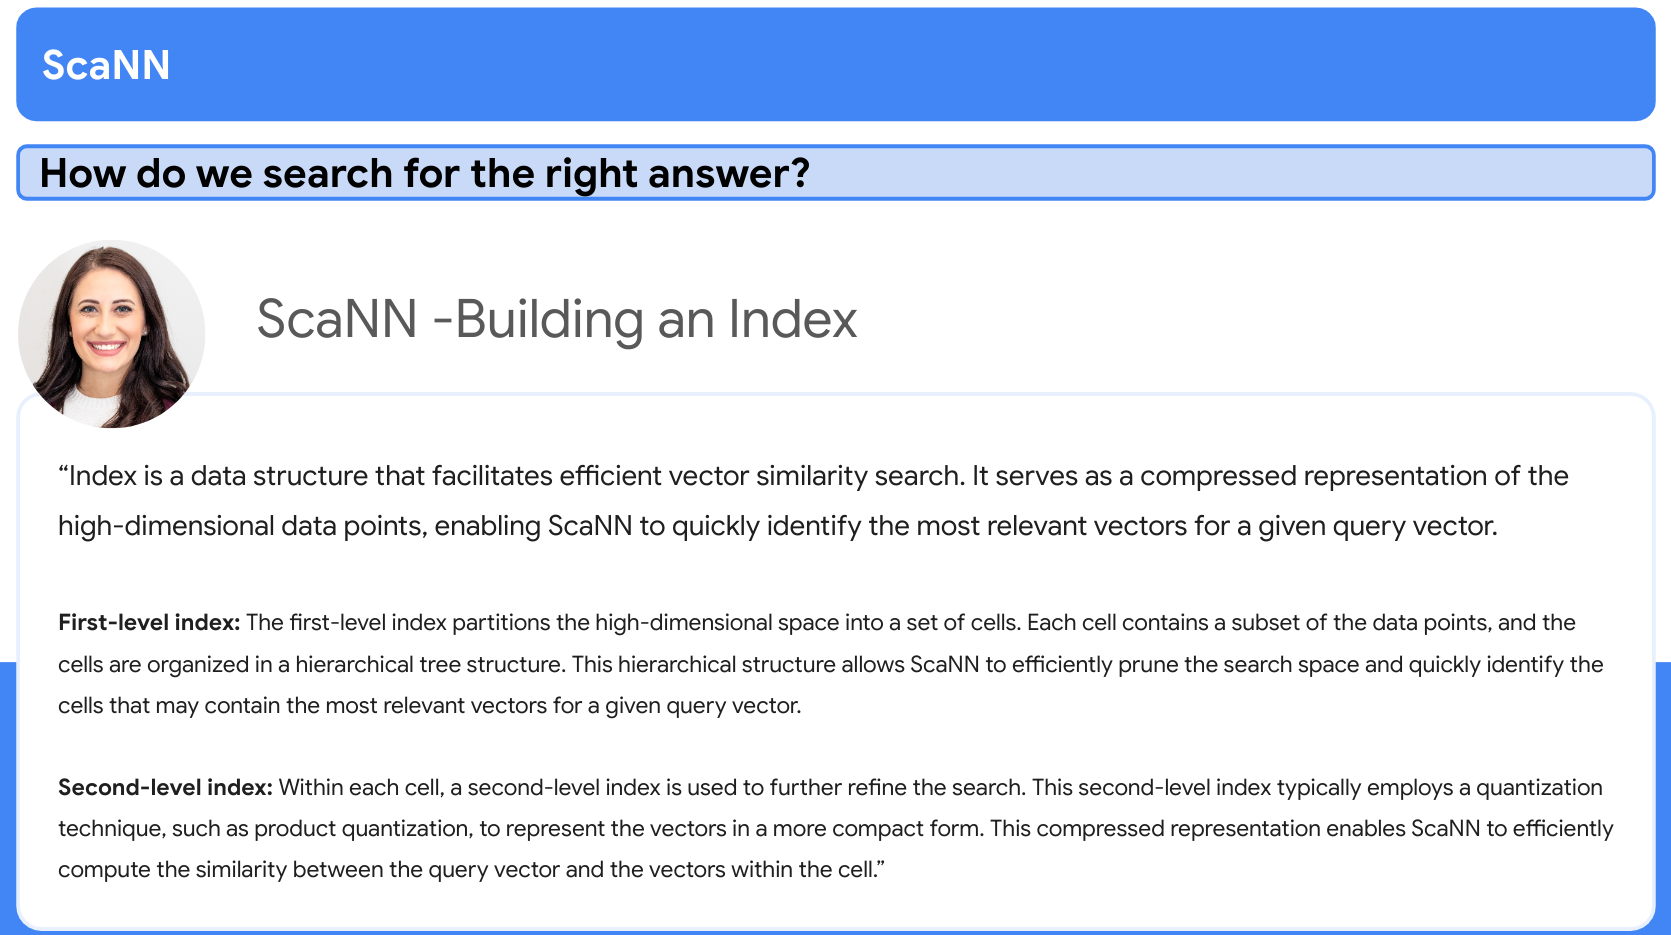

In [37]:
Image("img/priya_10.png", width=800)

In [38]:
###
# Indexing 
# The code then iterates through the documents list. 
# For each document, it checks if the document has text.
# If the document has text, it copies the document's embedding to the index array.
# The embedding is copied to the row of the index array that corresponds to the document's index in the documents list.
### 

if type(documents[0]['embedding']) == list:
    for i in range(index.shape[0]):
        if documents[i]['page_content']:
            index[i] = documents[i]['embedding']

In [39]:
# Normalizing Index
# The resulting normalized_index matrix has the same shape as the index matrix, but its rows have been normalized to have a length of 1.
# This can be useful for certain machine learning tasks, such as cosine similarity.
normalized_index = index / np.linalg.norm(index, axis=1)[:, np.newaxis]

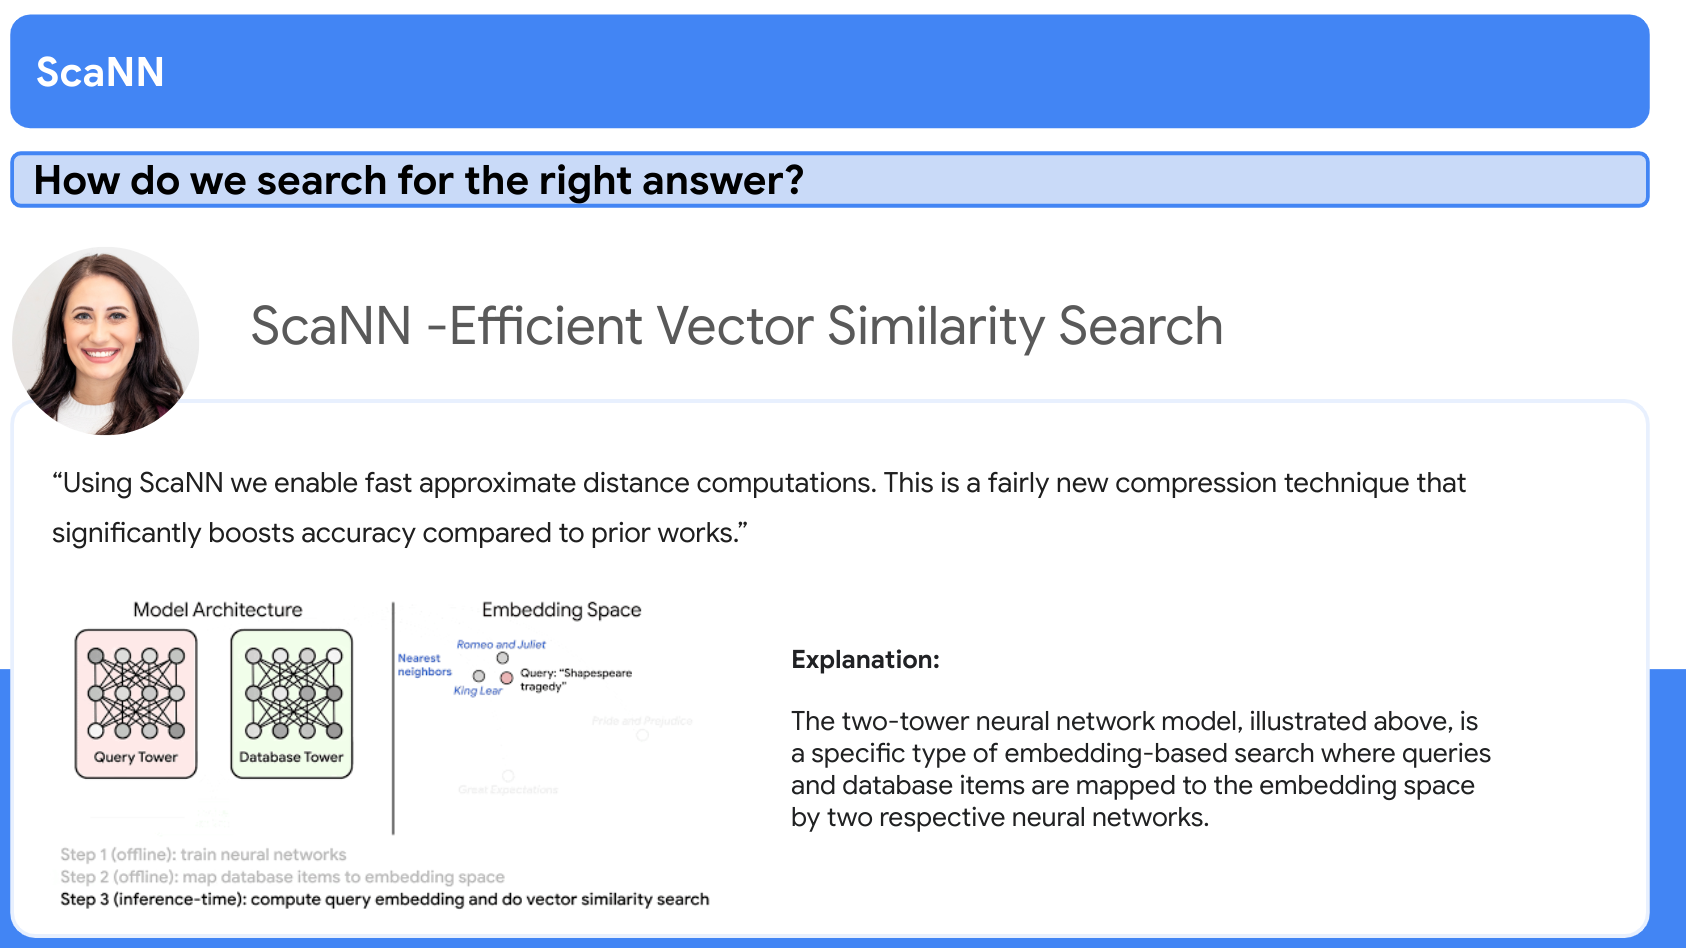

In [40]:
Image("img/priya_8.png", width=800)

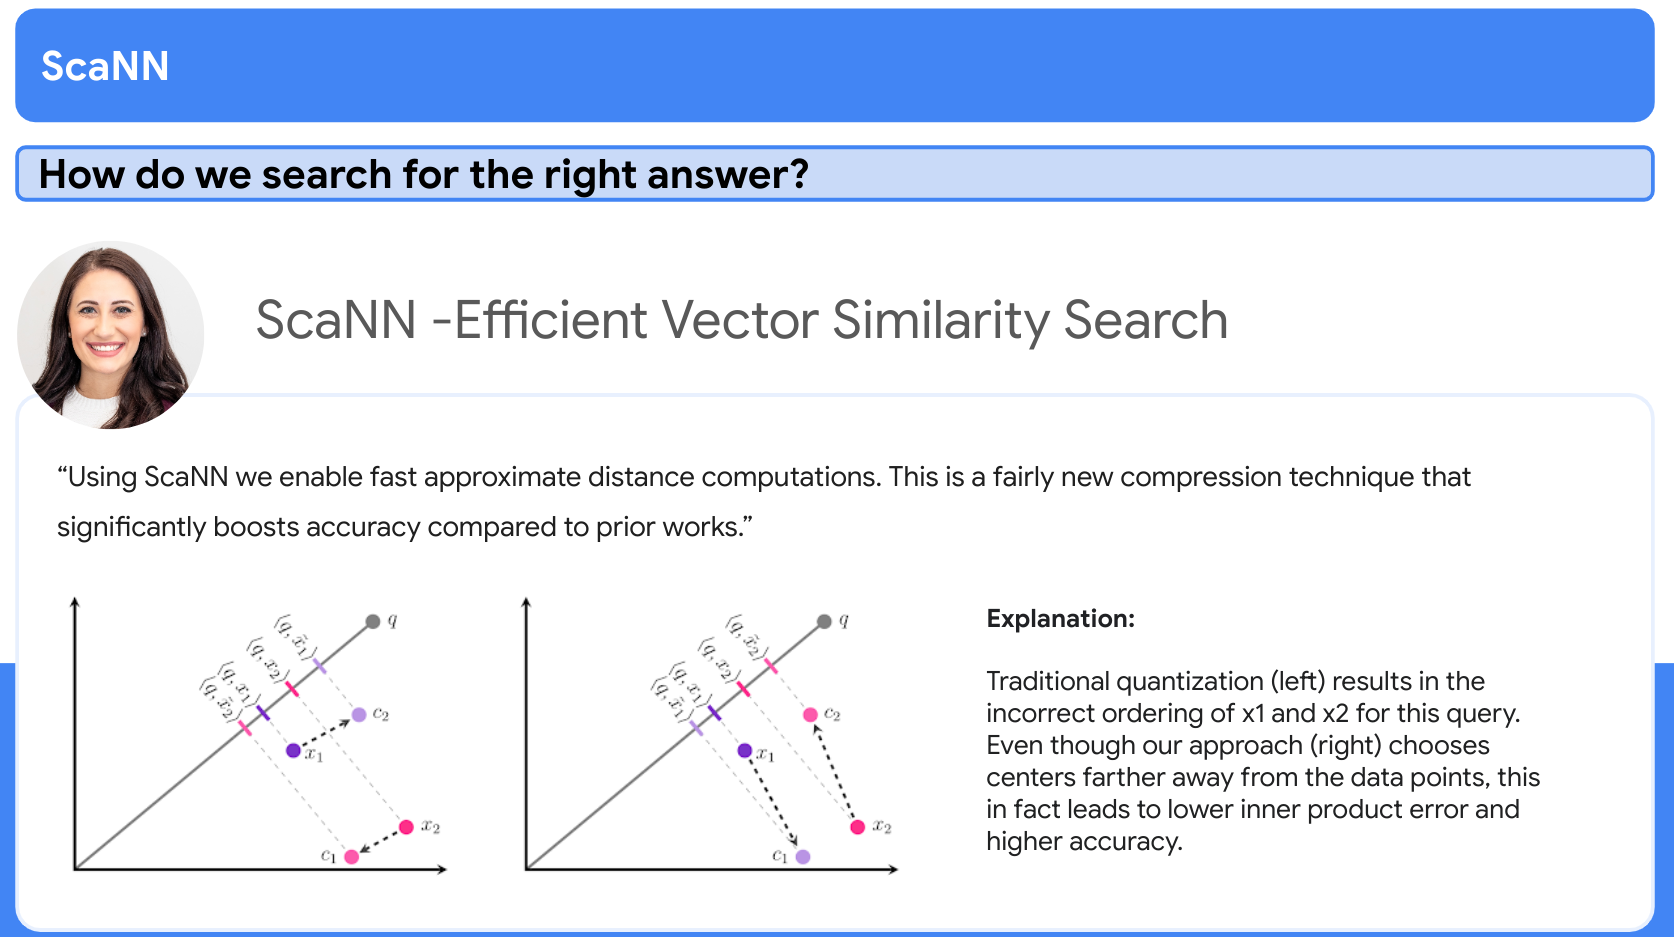

In [41]:
Image("img/priya_9.png", width=800)

In [42]:
###
# This code builds a TensorFlow-compatible searcher using SCANN, a library for approximate nearest neighbor search. SCANN uses techniques such as quantization and hashing to make approximate nearest neighbor search much faster than exact nearest neighbor search.
# 1) Create a SCANN builder: The code first creates a SCANN builder using the scann.scann_ops_pybind.builder() function. The builder takes three arguments:
# normalized_index: The normalized index matrix
# num_neighbors: The number of nearest neighbors to return for each query
# distance_measure: The distance measure to use for nearest neighbor search. In this case, the distance measure is "dot_product", which is the cosine similarity between two vectors.

# 2) Create a SCANN tree: The code then creates a SCANN tree using the builder.tree() function. The tree takes three arguments:
# num_leaves: The number of leaves in the tree. The number of leaves determines the trade-off between accuracy and search time. A higher number of leaves will result in more accurate searches, but it will also make the searches slower.
# num_leaves_to_search: The number of leaves to search for each query. This parameter is similar to num_leaves, but it allows you to trade off accuracy for search time on a per-query basis.
# training_sample_size: The size of the training sample used to construct the tree. A larger training sample will result in a more accurate tree, but it will also make the tree construction process slower.

# 3) Apply score AH transformation: The code then applies the score AH transformation to the tree using the score_ah() function. The score AH transformation is a technique that can improve the accuracy of SCANN searches.

# 4) Apply anisotropic quantization: The code then applies anisotropic quantization to the tree using the anisotropic_quantization_threshold argument. Anisotropic quantization is a technique that can further improve the accuracy of SCANN searches.
# 5) Reorder the tree: The code then reorders the tree using the reorder() function. Reordering the tree can improve the search performance of SCANN.
# 6) Build the searcher: The code finally builds the searcher using the build() function. The searcher is the object that you will use to perform nearest neighbor searches.

# The resulting searcher can be used to perform nearest neighbor searches using the search() method. The search() method takes a query vector as input and returns a list of the nearest neighbors of the query vector.

builder = scann.scann_ops_pybind.builder(
    normalized_index, # index
    10, # num_neighbors
    "dot_product" # distance_measure
    )

searcher = builder.tree(
    num_leaves=index.shape[0], #num_leaves
    num_leaves_to_search=index.shape[0], #num_leaves_to_search
    training_sample_size=index.shape[0]
    ).score_ah(
      2,
      anisotropic_quantization_threshold=0.2
      ).reorder(
          index.shape[0]
          ).build()

2023-11-20 10:16:59.517110: I scann/partitioning/partitioner_factory_base.cc:59] Size of sampled dataset for training partition: 276
2023-11-20 10:16:59.561080: I ./scann/partitioning/kmeans_tree_partitioner_utils.h:84] PartitionerFactory ran in 43.862081ms.


In [43]:
###
# This code defines a function search_index() that takes a query text string and the number of nearest neighbors to return (k) as input and returns a list of (neighbor document index, distance) tuples. The function performs the following steps:

# 1) Prints the query text: It prints the query text to the console.
# 2) Generates embeddings: It generates embeddings for the query text using the embedding_model. The embedding_model is assumed to be an object that has a get_embeddings() method that takes a list of text strings as input and returns a list of embedding vectors. The get_embeddings() method is expected to return a list of embedding vectors, where each embedding vector is a NumPy array of values.
# 3) Prints the embeddings: It prints the generated embeddings to the console.
# 4) Performs nearest neighbor search: It uses the searcher object to perform nearest neighbor search on the query embedding. The searcher object is assumed to be a SCANN searcher that has been created using the code in the previous question. The final_num_neighbors argument specifies the number of nearest neighbors to return.
# 5) Returns neighbor indices and distances: It returns a list of (neighbor document index, distance) tuples, where each tuple represents a nearest neighbor of the query. The neighbor document index is the index of the nearest neighbor in the documents list, and the distance is the distance between the query embedding and the neighbor embedding.

# In summary, this function takes a query text string and the number of nearest neighbors to return, generates embeddings for the query, performs nearest neighbor search using a SCANN searcher, and returns a list of (neighbor document index, distance) tuples representing the nearest neighbors of the query.

def search_index(query, k):
    #print("Query: ",query)
    query = embedding_model.get_embeddings([query])[0].values
    #print("Query: ",query)
    neighbors, distances = searcher.search(query, final_num_neighbors=k)
    return list(zip(neighbors, distances))

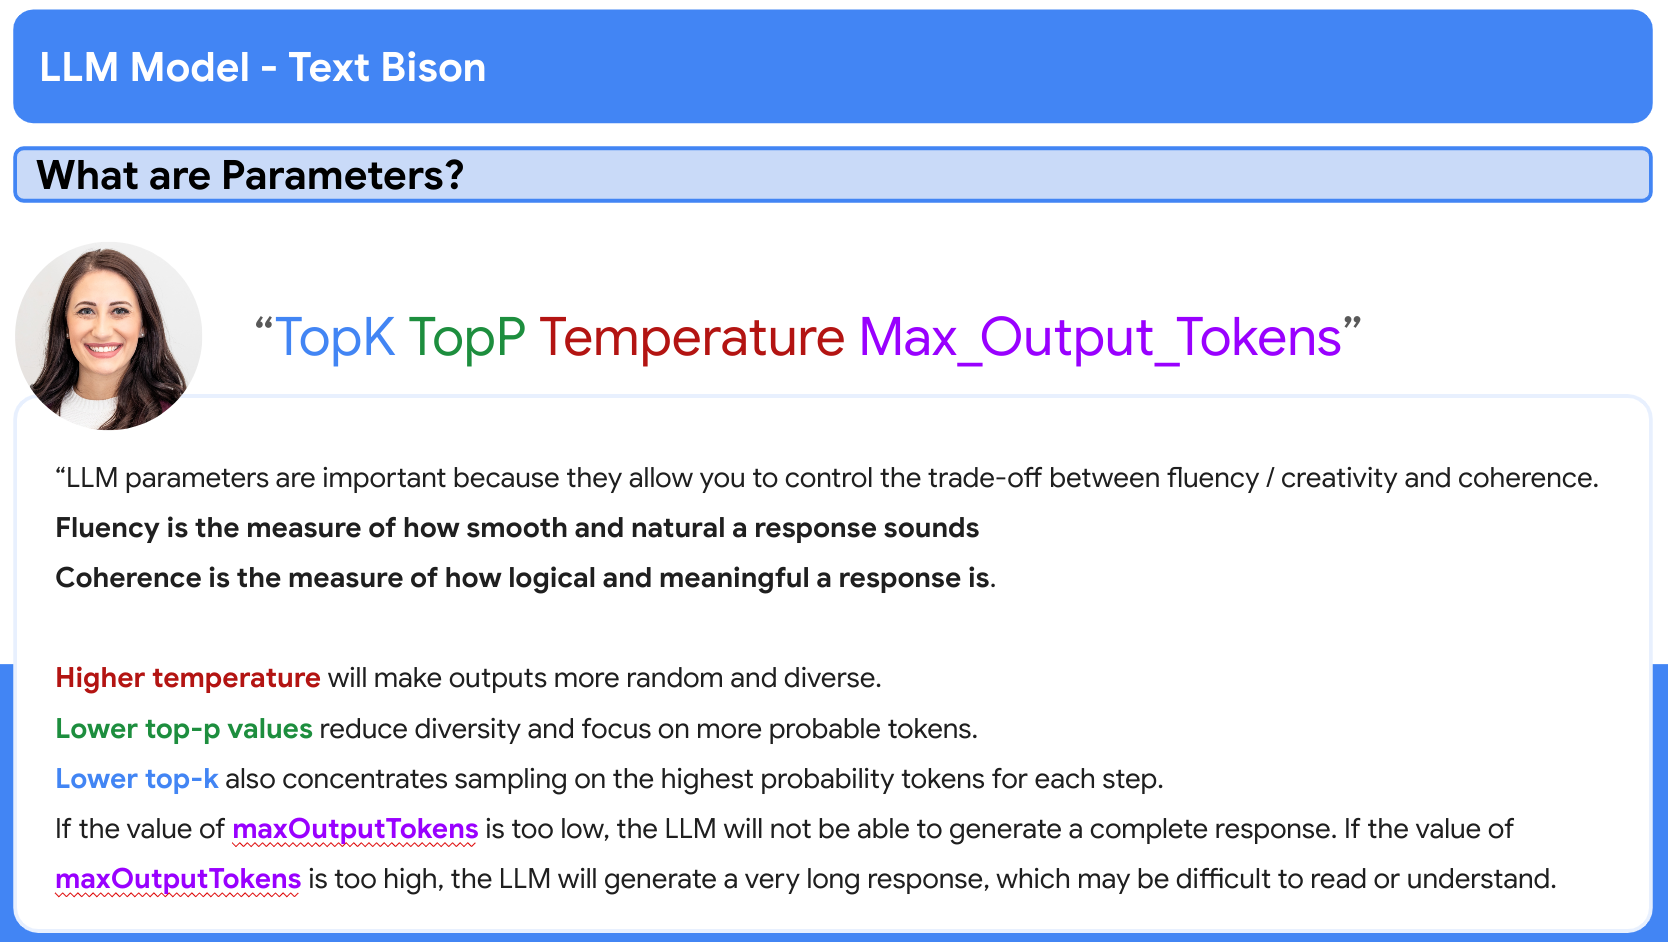

In [44]:
Image("img/priya_3.png", width=800)

In [45]:
# Example Questions:
question_1 = "What are essential amenities for guests?"
question_2 = "How much is the minimum cancellation fee for Hosts on Cymbal for a confirmed reservation?"
question_3 = "How old is Barack Obama?"
question_4 = "Is it a nice time travelling to Sydney in June?"

instructions_1 = "If the question can be answered by the context provided above alone than only use the context to provide the answer. However, never use other information than from the context above to formulate the answer!"
instructions_2 = "If the prompt does not contain a travel specific question then do not contiune. Instead end the conversation with: This is not a travel question, sorry I cannot answer this."
instructions_3 = "If the question cannot be answered by the context provided above but is a travel question then use the underlying LLM to answer. In particular state: the context above is not sufficient to answer the question but this is what I found in the base-model:"
# instructions_4 = "In case the context is not sufficient than ignore the following instructions and end the promot here! "

parameters = {
    "top_k": 40,  # A top_k of 1 means the selected token is the most probable among all tokens.
    "top_p": 0.8,  # Tokens are selected from most probable to least until the sum of their probabilities equals the top_p value.
    "temperature": 0.7,  # Temperature controls the degree of randomness in token selection.
    "max_output_tokens": 200,  # Token limit determines the maximum amount of text output.
    }


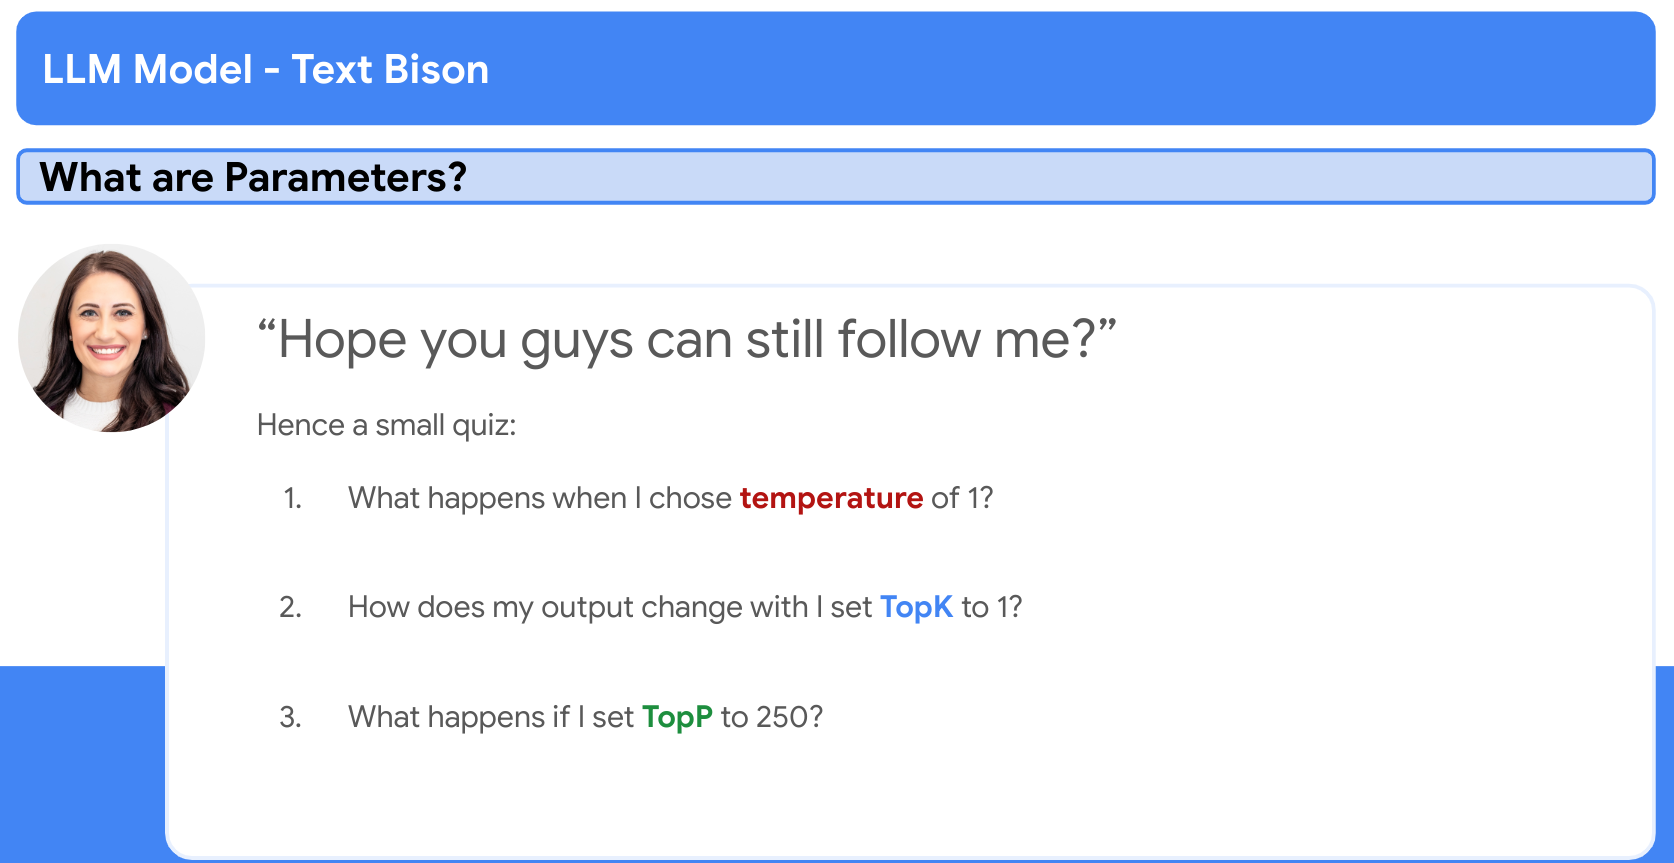

In [46]:
Image("img/priya_4.png", width=800)

In [47]:
# Example Question Embedding Space:
# print(embedding_model.get_embeddings(["How is the weather"])[0].values)
# print(len(embedding_model.get_embeddings(["How is the weather"])[0].values))
embedding_model.get_embeddings([example_question])[0].values[0:5]


[0.007953052408993244,
 -0.01183184515684843,
 -0.012116610072553158,
 0.06939463317394257,
 0.030111197382211685]

In [48]:
##
# The document_bot function is designed to provide a comprehensive answer to a given question by leveraging a combination of text generation,
# search, and visual highlighting. It takes a question as input and performs the following steps:

# 1) Search for relevant documents: Utilizes a search index to retrieve documents that are topically similar to the given question.
# 2) Generate a prompt: Constructs a detailed prompt for the text generation model, providing it with the context of the relevant documents and the question itself.
# 3) Generate an answer: Employs a text generation model to produce a comprehensive response to the question, drawing upon the information from the provided contexts.

# 4) Identify the most likely source: Determines the document from which the generated response is most likely derived.

# 5) Format the response: Packages the answer, its rationale, and the relevant sources into a structured and informative format.

# 6) Highlight the answer in the source document: Visualizes the answer by highlighting the corresponding text region within the identified source document.



def document_bot(question, parameters):

    # Get the score for the closest match
    score = search_index(question, k = 1)[0][1]
    print("Score: ", score)

    # retrieve related documents - the nubmer is based on the distance score from the closest match
    relevant_documentation = search_index(question, k = 1 + 2*int(10*(1-score)))

    # prepare context for prompt
    context = "\n".join([f'Context {c+1}:\n' + documents[doc[0]]['page_content'] for c, doc in enumerate(relevant_documentation)])

    # construct the prompt
    prompt = f"""
        Give a detailed answer to the question using information from the provided contexts.
        {context}
        Also include these Instructions:
        {instructions_1}
        {instructions_2}     
        {instructions_3}     

        Question:
        {question}

        Answer and Explanation:
    """

    response = textgen_model.predict(prompt, **parameters,)
    
    # get closest document to the response:
    likely_source = search_index(response.text, k=1)[0]
    print("Closest document: ", likely_source)

    # declare likely source: if closest document to response was in context pick it, otherwise pick first context match
    if likely_source[0] in [rd[0] for rd in relevant_documentation]:
        likely = True
        likely_document = documents[likely_source[0]]
        print("Likelyly: ", likely_source[1])
        print("Likelyly: ", likely_source[0])
        
        
    else:
        likely = False
        likely_document = documents[relevant_documentation[0][0]]


    sources = "\n".join(f"* {documents[doc[0]]['metadata']['source_document']}#page={documents[doc[0]]['metadata']['page']}\n\t* Document: {documents[doc[0]]['metadata']['filename']}, page: {documents[doc[0]]['metadata']['page']}, relevance to question: {doc[1]:.2f}" for doc in relevant_documentation)
    answer = f"""## Response
### Question
{question}

### Instructions
{instructions_1} \n
{instructions_2}  \n 
{instructions_3}   \n


### Answer
{response.text}

### Potenial Sources
{sources}
    """
    IPython.display.display(IPython.display.Markdown(answer))

    #font = PIL.ImageFont.truetype("/usr/share/fonts/truetype/liberation/LiberationSans-Regular.ttf", 20)
    document_image = page_images[likely_document['metadata']['page']-1]
    vertices = documents[int(likely_document['metadata']['vme_id'])]['extras']['vertices']
    draw = PIL.ImageDraw.Draw(document_image).polygon([
        vertices[0]['x'], vertices[0]['y'],
        vertices[1]['x'], vertices[1]['y'],
        vertices[2]['x'], vertices[2]['y'],
        vertices[3]['x'], vertices[3]['y']
    ], outline = 'green', width = 5)
    IPython.display.display(document_image.resize((800, 1000)))

    return

In [49]:
question = question_4
print(question)

Is it a nice time travelling to Sydney in June?


In [50]:
textgen_model.predict(question, **parameters)

Sydney is a great place to visit in June. The weather is generally mild and sunny, with average temperatures ranging from 15-25 degrees Celsius. There are also plenty of events and activities happening in the city, such as the Vivid Sydney light festival and the Sydney Opera House's annual season of outdoor concerts.

Score:  0.59724796
Closest document:  (54, 0.6517372)


## Response
### Question
Is it a nice time travelling to Sydney in June?

### Instructions
If the question can be answered by the context provided above alone than only use the context to provide the answer. However, never use other information than from the context above to formulate the answer! 

If the prompt does not contain a travel specific question then do not contiune. Instead end the conversation with: This is not a travel question, sorry I cannot answer this.  
 
If the question cannot be answered by the context provided above but is a travel question then use the underlying LLM to answer. In particular state: the context above is not sufficient to answer the question but this is what I found in the base-model:   



### Answer
The context above is not sufficient to answer the question but this is what I found in the base-model:

Sydney is a great place to visit any time of year, but June is a particularly good time to go. The weather is mild and sunny, with average temperatures ranging from 15°C to 25°C. There are also plenty of events and activities happening in the city, including the Sydney Festival, the Vivid Sydney light festival, and the Royal Easter Show.

### Potenial Sources
* full_cymbal_stay.pdf#page=28
	* Document: full_cymbal_stay.pdf, page: 28, relevance to question: 0.60
* full_cymbal_stay.pdf#page=3
	* Document: full_cymbal_stay.pdf, page: 3, relevance to question: 0.59
* full_cymbal_stay.pdf#page=24
	* Document: full_cymbal_stay.pdf, page: 24, relevance to question: 0.57
* full_cymbal_stay.pdf#page=24
	* Document: full_cymbal_stay.pdf, page: 24, relevance to question: 0.57
* full_cymbal_stay.pdf#page=11
	* Document: full_cymbal_stay.pdf, page: 11, relevance to question: 0.57
* full_cymbal_stay.pdf#page=3
	* Document: full_cymbal_stay.pdf, page: 3, relevance to question: 0.57
* full_cymbal_stay.pdf#page=28
	* Document: full_cymbal_stay.pdf, page: 28, relevance to question: 0.57
* full_cymbal_stay.pdf#page=21
	* Document: full_cymbal_stay.pdf, page: 21, relevance to question: 0.56
* full_cymbal_stay.pdf#page=24
	* Document: full_cymbal_stay.pdf, page: 24, relevance to question: 0.56
    

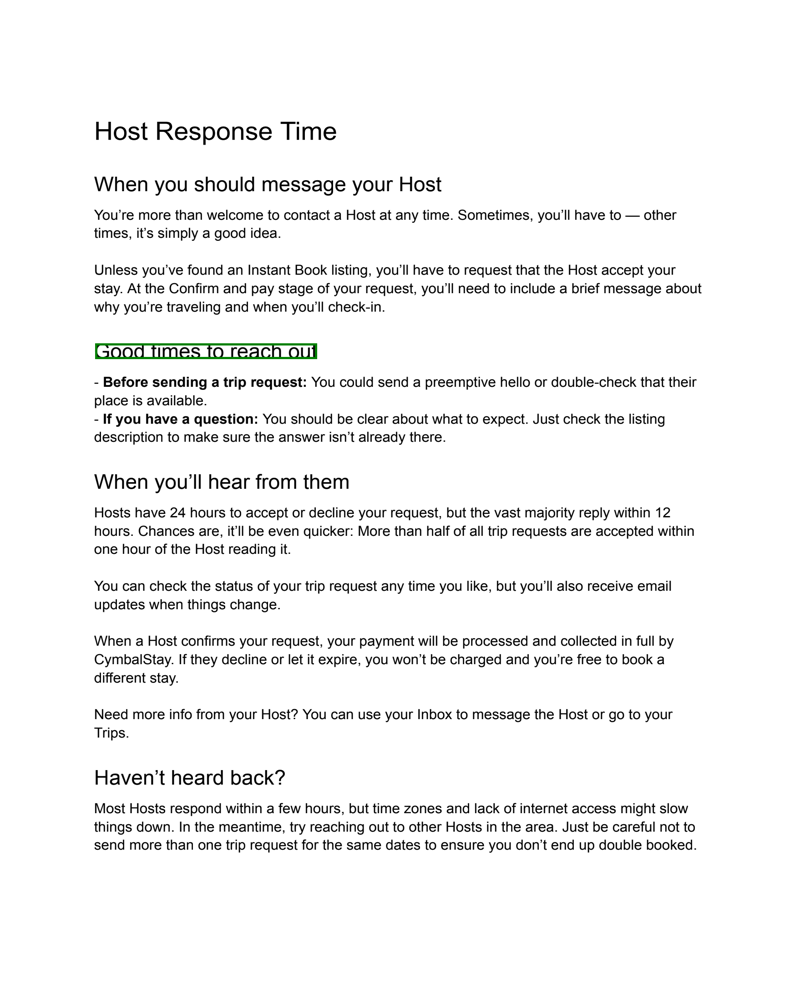

In [51]:
document_bot(question, parameters)